 # Plotting ML Outputs for Paper

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay,precision_recall_curve,PrecisionRecallDisplay

In [10]:
def combine_data(df,n=250,r=0):
    df_5 = df.loc[(df['material']=='PG5') ].sample(n,random_state=r)
    df_10 = df.loc[(df['material']=='PG10') ].sample(n,random_state=r)
    df_20 = df.loc[(df['material']=='PG20')].sample(n,random_state=r)
    df_in = pd.concat([df_5,df_10,df_20])
    a = ['PG5']  * n
    b = ['PG10'] * n
    c = ['PG20'] * n
    true_values = a + b + c

    df_in = df_in[[str(x) for x in np.arange(0,1900)]]

    df_in.reset_index(inplace=True,drop=True)

    return df_in,true_values

def prepare_results(loaded_model,df_in,true_values):
    features = list(str(int(a)) for a in np.concatenate([np.linspace(0,600,601),np.linspace(1200,1899,700)]))
    predictions = loaded_model.predict(df_in.loc[:,features])
    predictions.columns = ['PG10','PG20','PG5']
    predictions_arg = predictions.idxmax(axis='columns')

    results = pd.DataFrame({
        'predicted':predictions_arg, 
        'actual':true_values, 
        'confidence':predictions.max(axis=1), 
        'PG20_conf':predictions['PG20'],
        'PG10_conf':predictions['PG10'],
        'PG5_conf':predictions['PG5']})

    results['correct_prediction']=False
    results.loc[results['actual']==results['predicted'],'correct_prediction']=True

    return results

def con_mat_plot(data_for_plot,target='predicted'):

    acc_score = accuracy_score(data_for_plot['actual'],data_for_plot[target])
    print(f'accuracy: {acc_score:.2f}')
    cm = confusion_matrix(data_for_plot['actual'], data_for_plot[target],normalize='true', labels = ['PG5','PG10','PG20'])

    fig, ax = plt.subplots(
        figsize = (5,4),dpi=75
    )

    sns.heatmap(
        data = cm*100,
        vmin=0, vmax=100,
        annot=True, fmt=".0f",
        xticklabels=['PG5','PG10','PG20'],
        yticklabels=['PG5','PG10','PG20'],
        cmap='Blues',
        cbar_kws={'label': 'Proportion (%)'}
        )

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('(b)',fontweight='bold')
    plt.tight_layout()
    plt.savefig('figures/Figure 8(b).png',dpi=300)

    plt.show()

## Import Trained Model

In [3]:
model_path_reordered = Path('data/output/trained_model')
loaded_model = mlflow.pyfunc.load_model(model_path_reordered.as_posix())

/Users/user/opt/anaconda3/envs/py380/lib/python3.8/site-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


### Inter Batch

accuracy: 0.69


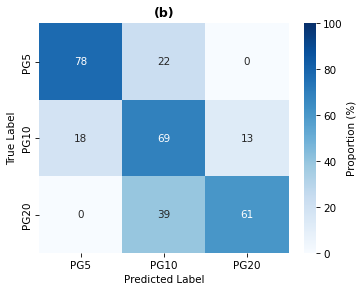

In [11]:
file = Path.cwd().joinpath('data','input','puregraph_size_comparison_Y.csv')
df_inter = pd.read_csv(file)

df_inter_in,true_values = combine_data(df_inter,250,88)
results = prepare_results(loaded_model,df_inter_in,true_values)
con_mat_plot(results)